In [53]:
# Install TensorFlow
# import tensorflow as tf
# import tensorflow.keras as keras
# from tensorflow.keras.models import Model, Sequential, load_model
# from tensorflow.keras.layers import Dense, Dropout, Flatten , Convolution2D, MaxPooling2D , Lambda, Conv2D, Activation,Concatenate, Input, BatchNormalization
# from tensorflow.keras.optimizers import Adam , SGD , Adagrad
# from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, CSVLogger, ReduceLROnPlateau
# from tensorflow.keras.utils import to_categorical
# from tensorflow.keras import regularizers , initializers
# import tensorflow.keras.backend as K
# from sklearn.preprocessing import StandardScaler
# from joblib import dump, load


import numpy as np
from numpy import random
import matplotlib.pyplot as plt
# import autokeras as ak
import os 
import time
import importlib
import logging
from tqdm import tqdm

importlib.reload(logging)
logging.basicConfig(level = logging.INFO)

# # limit GPU memory
# gpus = tf.config.experimental.list_physical_devices('GPU')
# # if gpus:
# #   # Restrict TensorFlow to only use the first GPU
# try:
#     tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
#     tf.config.experimental.set_virtual_device_configuration(
#     gpus[0],
        
#     [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=10000)])
#     logical_gpus = tf.config.experimental.list_logical_devices('GPU')
#     print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
# except RuntimeError as e:
# # Visible devices must be set before GPUs have been initialized
#     print(e)

logging.info("numpy Version is {}".format(np.__version__))
# logging.info("autokeras Version is {}".format(ak.__version__))
# logging.info("tensorflow Version is {}".format(tf.keras.__version__))
logging.info("\n")

# !nvidia-smi
%config InlineBackend. figure_format = 'retina'

INFO:root:numpy Version is 1.19.5
INFO:root:



In [54]:
%%time
#Load Model
experiment = "dune"



theta23_resolution = {}
delta_resolution = {}
test_sample_statistics = range(500000 , 10500000, 500000)

for statistics in test_sample_statistics:
    theta23_resolution.update({"statistics_" + str(statistics):0},)
    delta_resolution.update({"statistics_" + str(statistics):0},)
    
for i, (statistics, nth_statistics) in enumerate(zip(theta23_resolution, test_sample_statistics)):
    
    file_path = "/dicos_ui_home/alanchung/ML4NO/Regression_std_Study/Study_test_sample_statistics/theta23_resolution_"+str(nth_statistics)+".npz"
    
    if os.path.isfile(file_path):
        theta23_resolution[statistics] = np.load(file_path, allow_pickle = True)["data"].item()

    else:
        logging.info("Please Check Input Files!!!")
        raise ValueError("Please Check Input Files!!!")
        
        
for i, (statistics, nth_statistics) in enumerate(zip(delta_resolution, test_sample_statistics)):
    
    file_path = "/dicos_ui_home/alanchung/ML4NO/Regression_std_Study/Study_test_sample_statistics/delta_resolution_"+str(nth_statistics)+".npz"
    
    if os.path.isfile(file_path):
        delta_resolution[statistics] = np.load(file_path, allow_pickle = True)["data"].item()

    else:
        logging.info("Please Check Input Files!!!")
        raise ValueError("Please Check Input Files!!!")
        
        
        
logging.info("\n")
logging.info("All Resolutions are loaded!")

INFO:root:

INFO:root:All Resolutions are loaded!


CPU times: user 3min 8s, sys: 21 s, total: 3min 29s
Wall time: 3min 30s


In [55]:
%%time

test_data = np.load('../Data/sample_NuFit0911.npz')
data_mid = np.column_stack([test_data["ve_"+str(experiment)][:,:36], test_data["vu_"+str(experiment)][:,:36], test_data["vebar_"+str(experiment)][:,:36], test_data["vubar_"+str(experiment)][:,:36]])
# data_mid = np.column_stack([data['ve_dune'], data['vu_dune'], data['vebar_dune'], data['vubar_dune']])
# data_mid = np.column_stack([data['ve_dune'], data['vu_dune'], data['vebar_dune'], data['vubar_dune'],data['ve_t2hk'], data['vu_t2hk'], data['vebar_t2hk'], data['vubar_t2hk']])
data_IO_mid = data_mid[0]
data_NO_mid = data_mid[1]

logging.info("Test IO Data Shape:{}".format(data_IO_mid.shape))
logging.info("Test NO Data Shape:{}".format(data_NO_mid.shape))


IO_or_NO = 0 # 0 for IO and 1 for NO


if IO_or_NO == 0:
    logging.info("IO")
    logging.info("True point: theta_23 = {:.2f} \delta_cp = {:.2f}".format(test_data['theta23'][0], test_data['delta'][0]))
    
#     data_asimov = data_IO_mid.reshape(1,data_IO_mid.shape[0])
#     data_poisson = random.poisson(data_IO_mid, size = (N, len(data_IO_mid)))
    ordering = "Inverse Ordering"
    
else:
    logging.info("NO")
    logging.info("True point: theta_23 = {:.2f} \delta_cp = {:.2f}".format(test_data['theta23'][1], test_data['delta'][1]))
    
#     data_asimov = data_NO_mid.reshape(1,data_NO_mid.shape[0])
#     data_poisson = random.poisson(data_NO_mid, size = (N, len(data_NO_mid)))
    ordering = "Normal Ordering"
    

INFO:root:Test IO Data Shape:(144,)
INFO:root:Test NO Data Shape:(144,)
INFO:root:IO
INFO:root:True point: theta_23 = 49.00 \delta_cp = 195.00


CPU times: user 5.99 ms, sys: 127 µs, total: 6.11 ms
Wall time: 4.6 ms


100%|██████████| 20/20 [00:00<00:00, 386.68it/s]


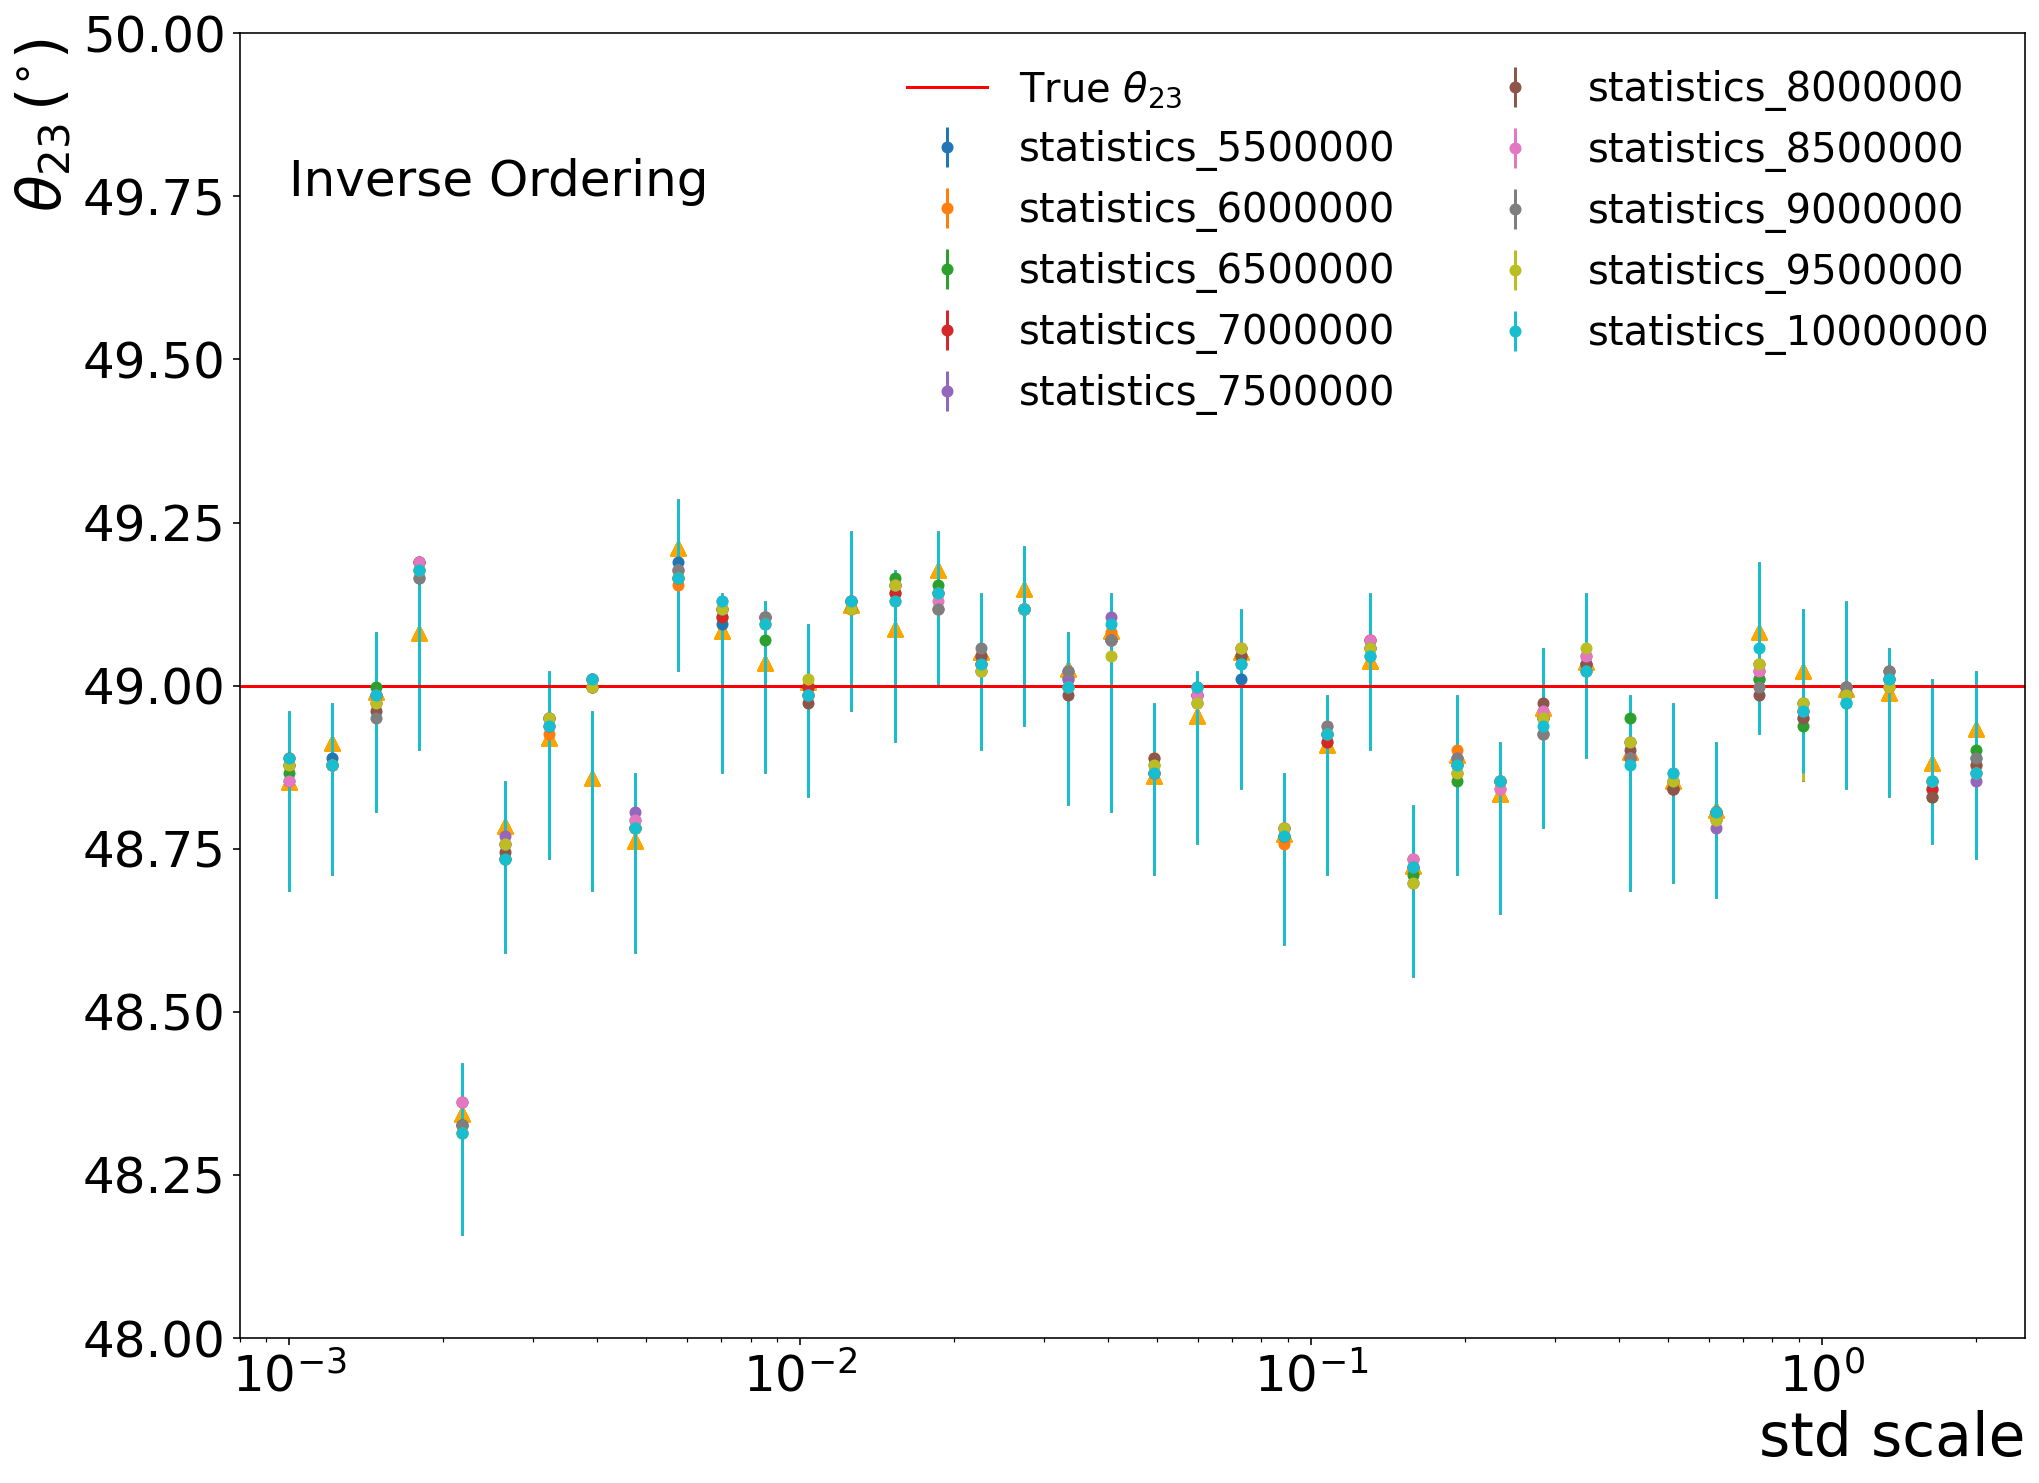

CPU times: user 886 ms, sys: 207 ms, total: 1.09 s
Wall time: 906 ms


In [89]:
%%time

fig, ax = plt.subplots(1,1, figsize=(16,12))



for i, element in enumerate(tqdm(theta23_resolution)):

    if i < 10:
        continue
    
    resolution = theta23_resolution[element]

    std_scale = np.logspace(-3, np.log10(2), 40)
    prediction_asimov = [resolution[std_scale]["asimov"] for std_scale in resolution if std_scale != "asimov"]
    best_fit = [resolution[std_scale]["best_fit"] for std_scale in resolution if std_scale != "asimov"]
    p_yerr = np.array([resolution[std_scale]["p_yerr"] for std_scale in resolution if std_scale != "asimov"]) - np.array(best_fit)
    n_yerr = np.array(best_fit) - np.array([resolution[std_scale]["n_yerr"] for std_scale in resolution if std_scale != "asimov"])
    uncertainty = [n_yerr, p_yerr]

    plt.scatter(std_scale, prediction_asimov, color='orange', marker = "^", s=50)#, label="Prediction for Asimov Data")
    plt.errorbar(std_scale, best_fit, yerr=uncertainty, fmt='o',ms=5, label= element)#, label="Predicted $\\theta_{23}$ (poisson included)")
plt.axhline(y=test_data['theta23'][IO_or_NO] , color='r', linestyle='-', label="True $\\theta_{23}$")

if IO_or_NO == 0:
#     plt.text(x=0.001,y=53.3, s="Inverse Ordering", fontsize=25 )
    plt.text(x=0.001,y=49.75, s="Inverse Ordering", fontsize=25 )
elif IO_or_NO == 1:
#     plt.text(x=0.001,y=53.3, s="Normal Ordering", fontsize=25 )
    plt.text(x=0.001,y=49.75, s="Normal Ordering", fontsize=25 )


ax.tick_params(axis='x', labelsize=25)
ax.tick_params(axis='y', labelsize=25)
plt.xlim((0.0008, 2.5))
plt.xscale("log")
# plt.ylim((44, 54))
plt.ylim((48, 50))
plt.xlabel("std scale", fontsize=30,horizontalalignment='right',x=1) 
plt.ylabel("$\\theta_{23}\,(^{\circ})$ ", fontsize=30, horizontalalignment='right',y=1)
# plt.grid()

# plt.legend(loc="best",ncol=2,fontsize=20, edgecolor = "w",fancybox=False, framealpha=0)
plt.legend(bbox_to_anchor=(1, 1),ncol=2,fontsize=20, edgecolor = "w",fancybox=False, framealpha=0)

# plt.savefig("./Plots/"+str(experiment)+"_"+str("to_5GeV")+"_"+str(ordering)+"_theta23_std_evolution.pdf", transparent=True, bbox_inches='tight') 


plt.show()

100%|██████████| 20/20 [00:00<00:00, 373.38it/s]


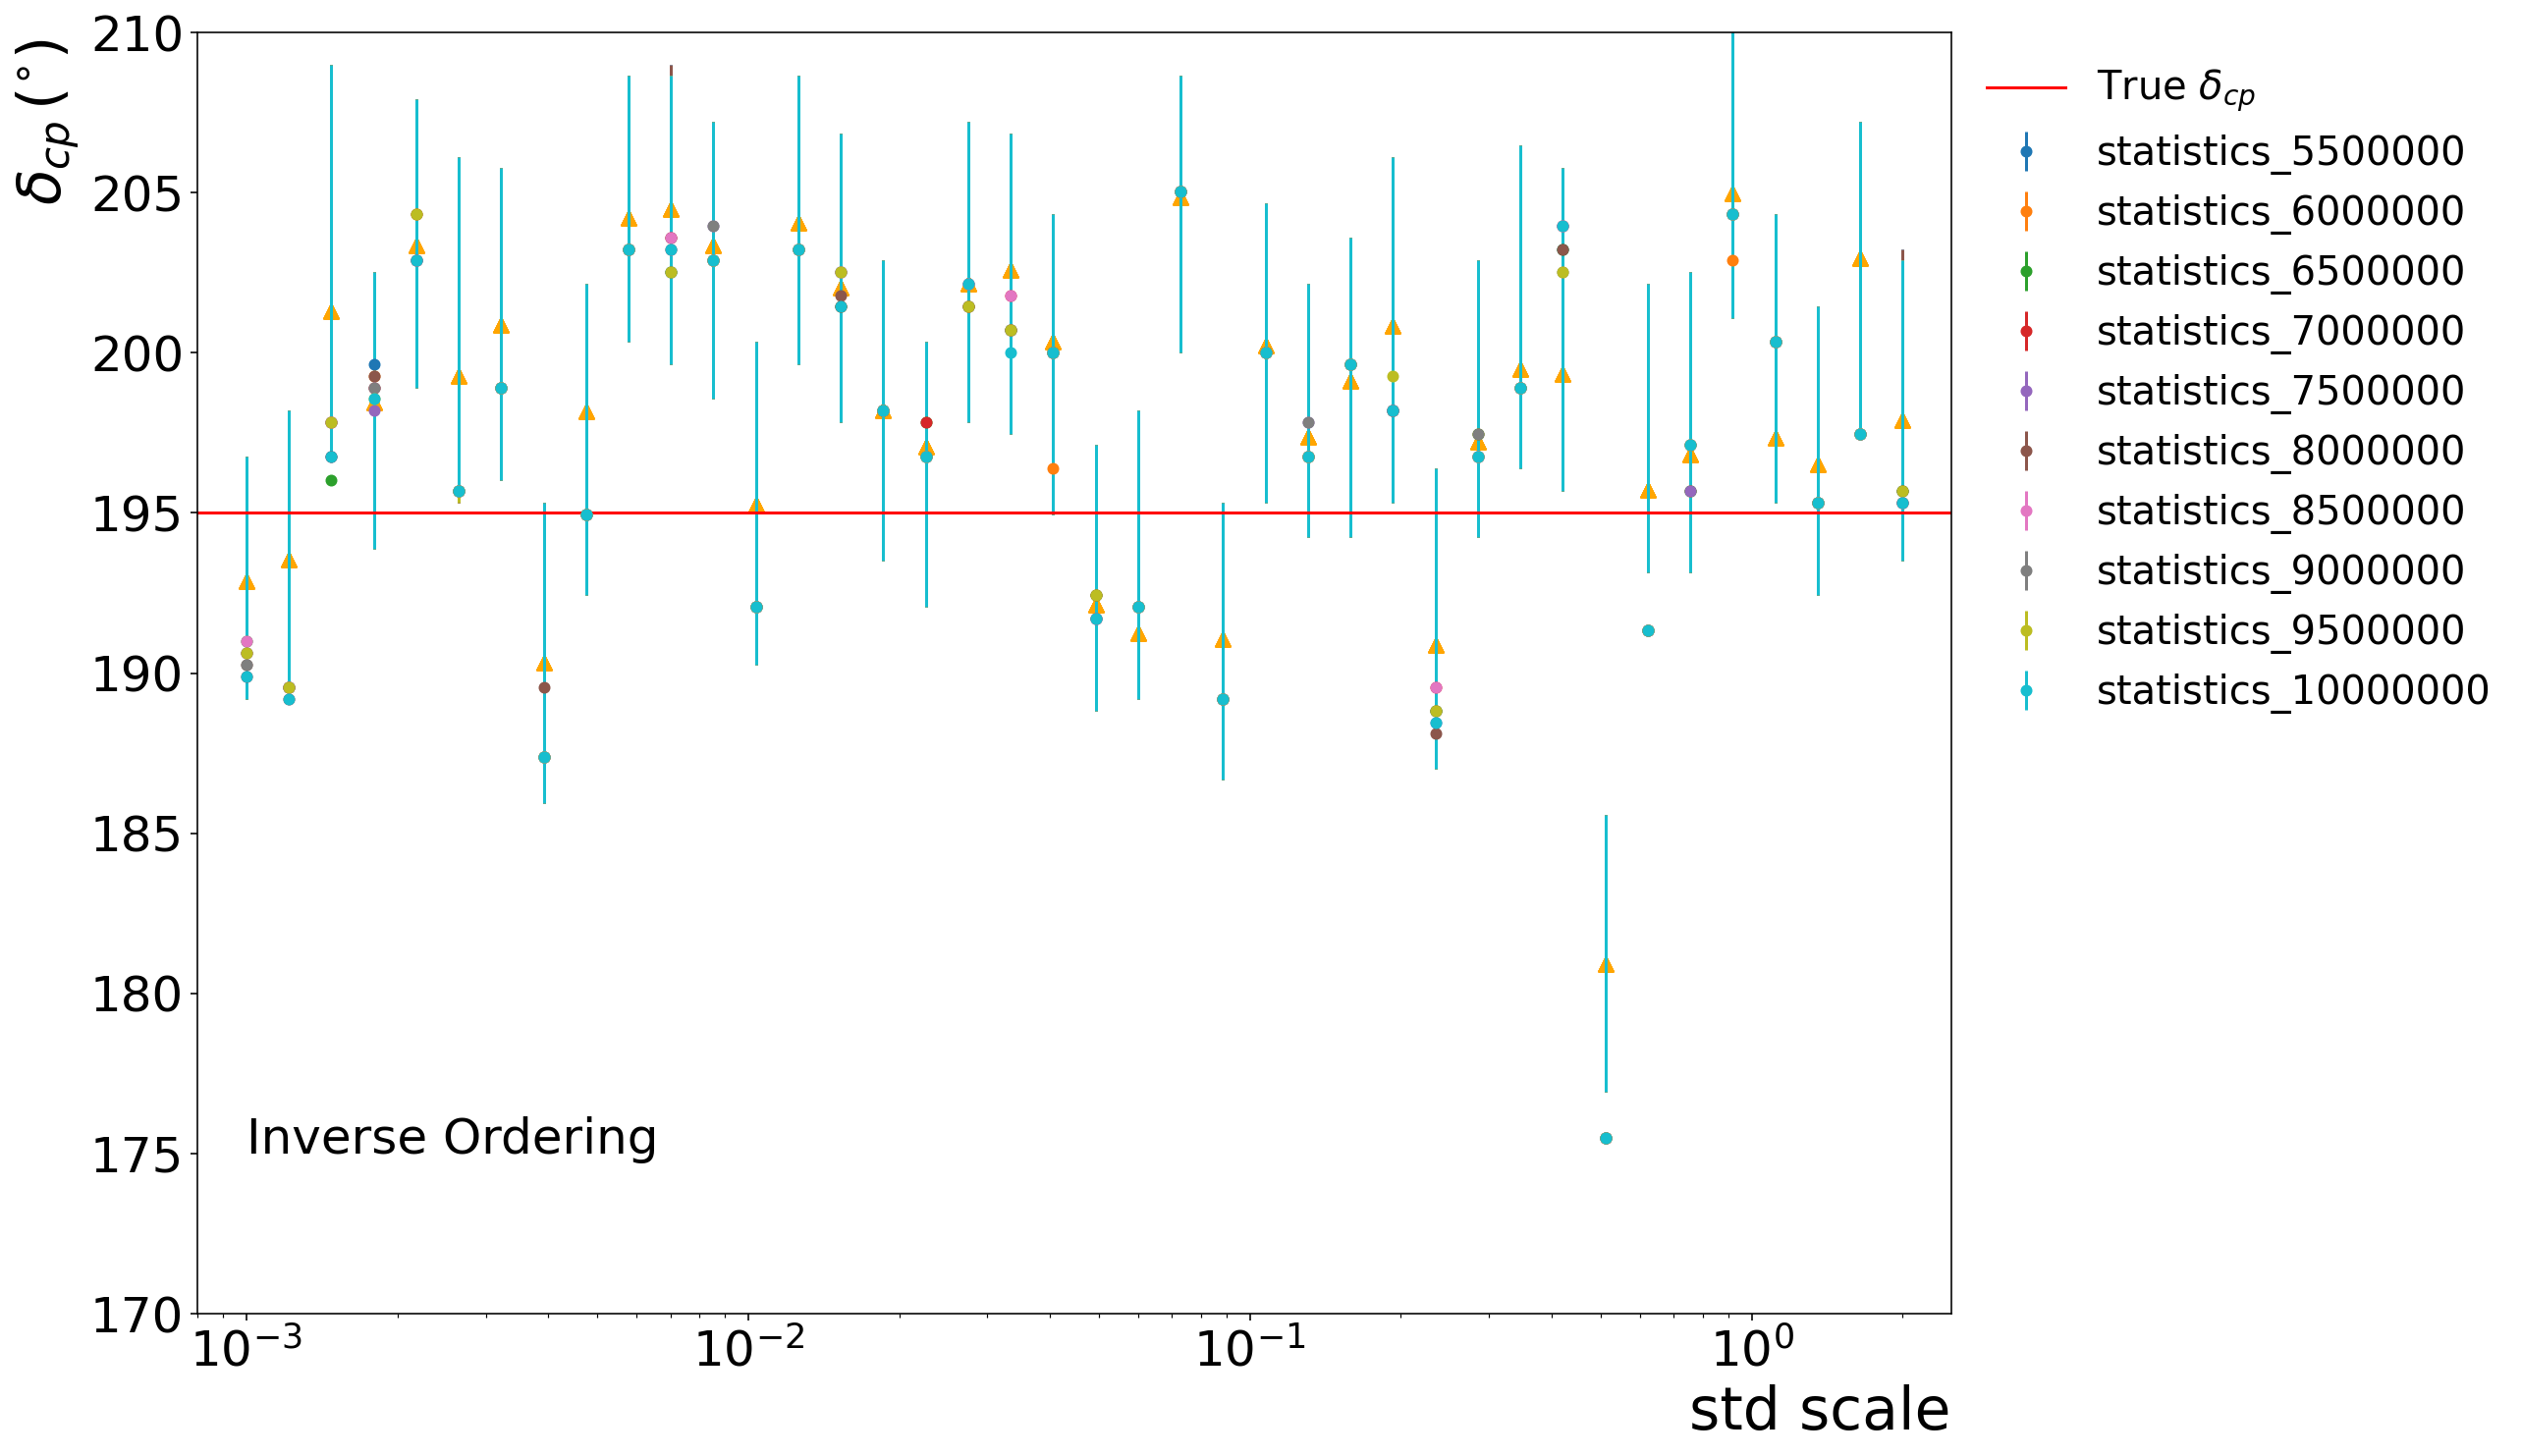

CPU times: user 932 ms, sys: 214 ms, total: 1.15 s
Wall time: 959 ms


In [91]:
%%time

fig, ax = plt.subplots(1,1, figsize=(16,12))

for i, element in enumerate(tqdm(delta_resolution)):
    
    if i < 10:
        continue
    
    resolution = delta_resolution[element]

    std_scale = np.logspace(-3, np.log10(2), 40)
    prediction_asimov = [resolution[std_scale]["asimov"] for std_scale in resolution if std_scale != "asimov"]
    best_fit = [resolution[std_scale]["best_fit"] for std_scale in resolution if std_scale != "asimov"]
    p_yerr = np.array([resolution[std_scale]["p_yerr"] for std_scale in resolution if std_scale != "asimov"]) - np.array(best_fit)
    n_yerr = np.array(best_fit) - np.array([resolution[std_scale]["n_yerr"] for std_scale in resolution if std_scale != "asimov"])
    uncertainty = [n_yerr, p_yerr]

    plt.scatter(std_scale, prediction_asimov, color='orange', marker = "^", s=50)#, label="Prediction for Asimov Data")
    plt.errorbar(std_scale, best_fit, yerr=uncertainty, fmt='o',ms=5,label=element)#, label="Predicted $\\theta_{23}$ (poisson included)")

plt.axhline(y=test_data['delta'][IO_or_NO] , color='r', linestyle='-', label="True $\delta_{cp}$")

if IO_or_NO == 0:
#     plt.text(x=0.001,y=238, s="Inverse Ordering", fontsize=25 )
#     plt.ylim((145, 245))
    plt.text(x=0.001,y=175, s="Inverse Ordering", fontsize=25 )
    plt.ylim((170, 210))
elif IO_or_NO == 1:
    plt.text(x=0.001,y=328, s="Normal Ordering", fontsize=25 )
    plt.ylim((236, 336))

ax.tick_params(axis='x', labelsize=25)
ax.tick_params(axis='y', labelsize=25)
plt.xlim((0.0008, 2.5))
plt.xscale("log")
plt.xlabel("std scale", fontsize=30,horizontalalignment='right',x=1) 
plt.ylabel("$\delta_{cp}\,(^{\circ})$ ", fontsize=30, horizontalalignment='right',y=1)

# plt.legend(loc="best",ncol=1,fontsize=20, edgecolor = "w",fancybox=False, framealpha=0)
plt.legend(bbox_to_anchor=(1, 1),ncol=1,fontsize=20, edgecolor = "w",fancybox=False, framealpha=0)

# plt.savefig("./Plots/"+str(experiment)+"_"+str("to_5GeV")+"_"+str(ordering)+"_delta_std_evolution.pdf", transparent=True, bbox_inches='tight') 
    

plt.show()

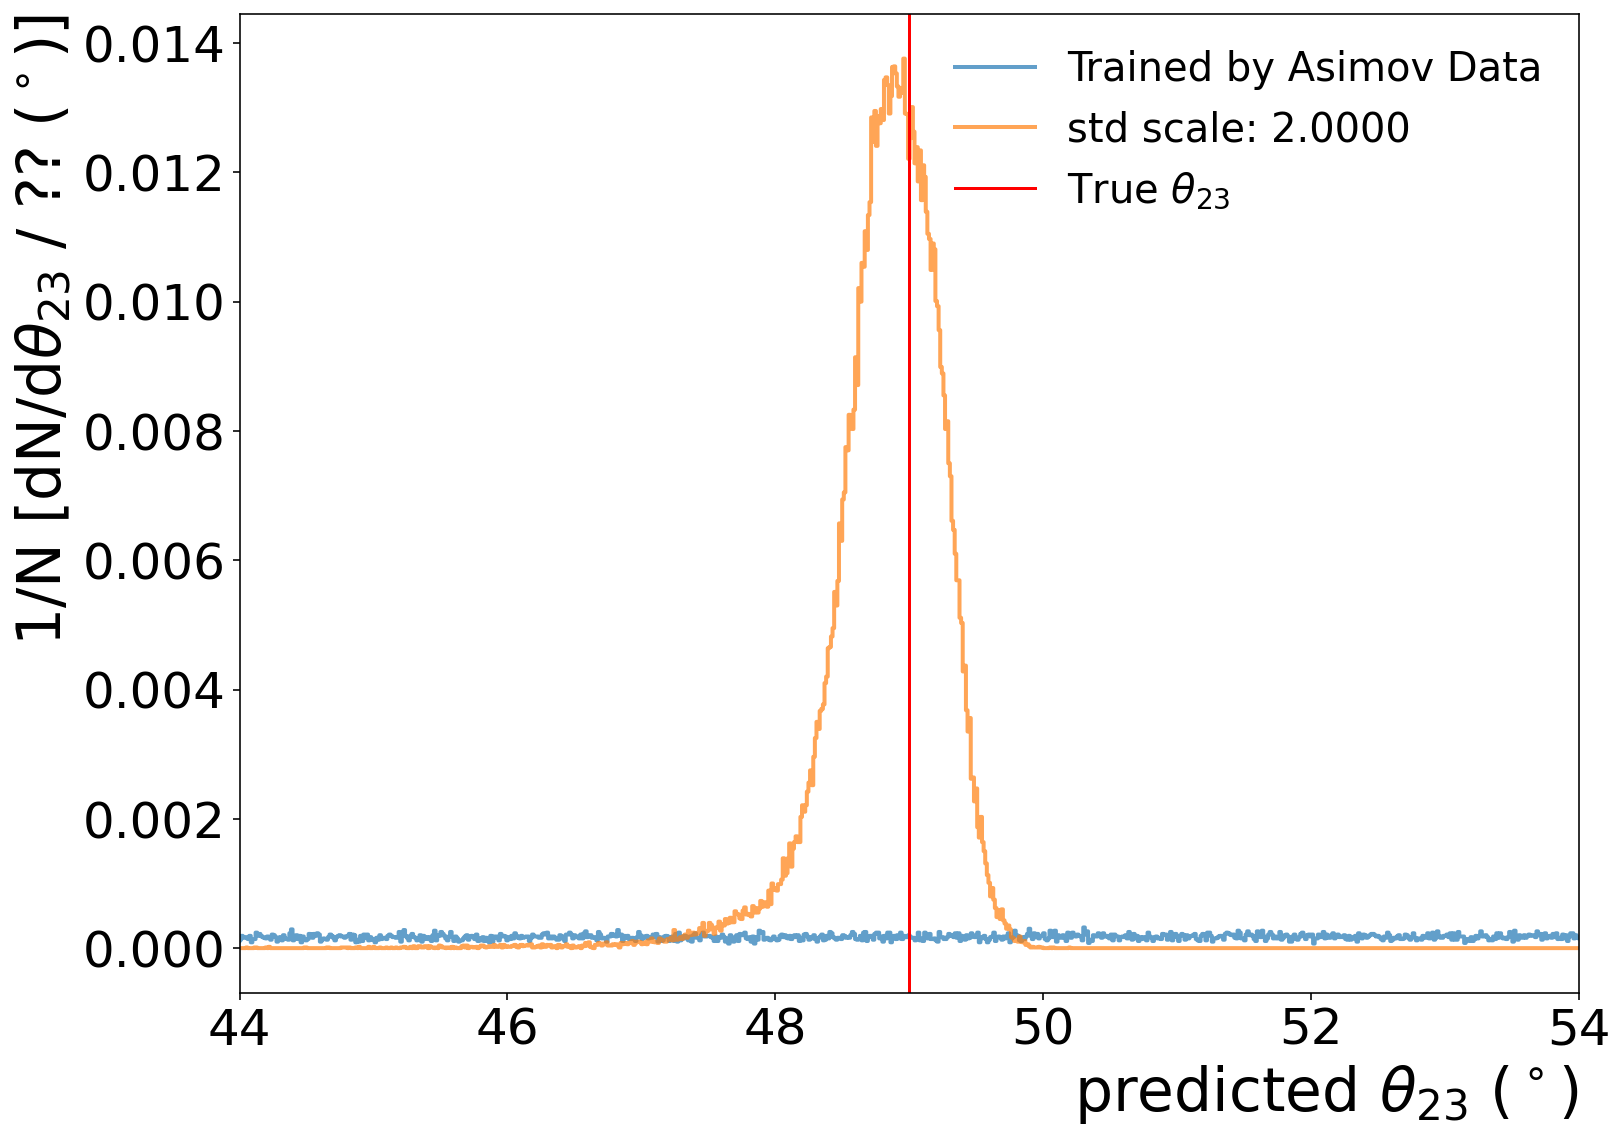

CPU times: user 365 ms, sys: 163 ms, total: 528 ms
Wall time: 347 ms


In [14]:
%%time
fig, ax = plt.subplots(1,1, figsize=(12,9))



"""
Trained by Asimov
"""
hist, bins = theta23_resolution["asimov"]["hist"], bins_theta23

plt.step(bins[:-1], 
         hist.astype(np.float32) / hist.sum() ,
#          hist.astype(np.float32) ,
         where='mid',
         linewidth=2, 
         alpha=0.7,
         label="Trained by Asimov Data"
        )

"""
Trained by Asymptotic Method
"""
# for i in scale_range[0,5,10,15,20,25,39]:
# for i in [0,5,10,15,25,37,38,39]:
for i in [39]:
    hist, bins = theta23_resolution["std_scale_"+str(i)]["hist"], bins_theta23
    
    plt.step(bins[:-1], 
             hist.astype(np.float32) / hist.sum() ,
    #          hist.astype(np.float32) ,
             where='mid',
             linewidth=2, 
             alpha=0.7,
             label="std scale: {:.4f}".format(np.logspace(-3, np.log10(2), 40)[i])
            )
    
    
plt.axvline(x=test_data['theta23'][IO_or_NO] , color='r', linestyle='-', label="True $\\theta_{23}$")

ax.tick_params(axis='x', labelsize=25)
ax.tick_params(axis='y', labelsize=25)
plt.xlim((44,54))
# plt.ylim((0., 0.18))
plt.xlabel("predicted $\\theta_{23}$ ($^\circ$)", fontsize=30,horizontalalignment='right',x=1) 
plt.ylabel("1/N [dN/d$\\theta_{23}$ / ?? ($^\circ$)]", fontsize=30, horizontalalignment='right',y=1)

plt.legend(loc="best",ncol=1,fontsize=20, edgecolor = "w",fancybox=False, framealpha=0)
    


plt.show()

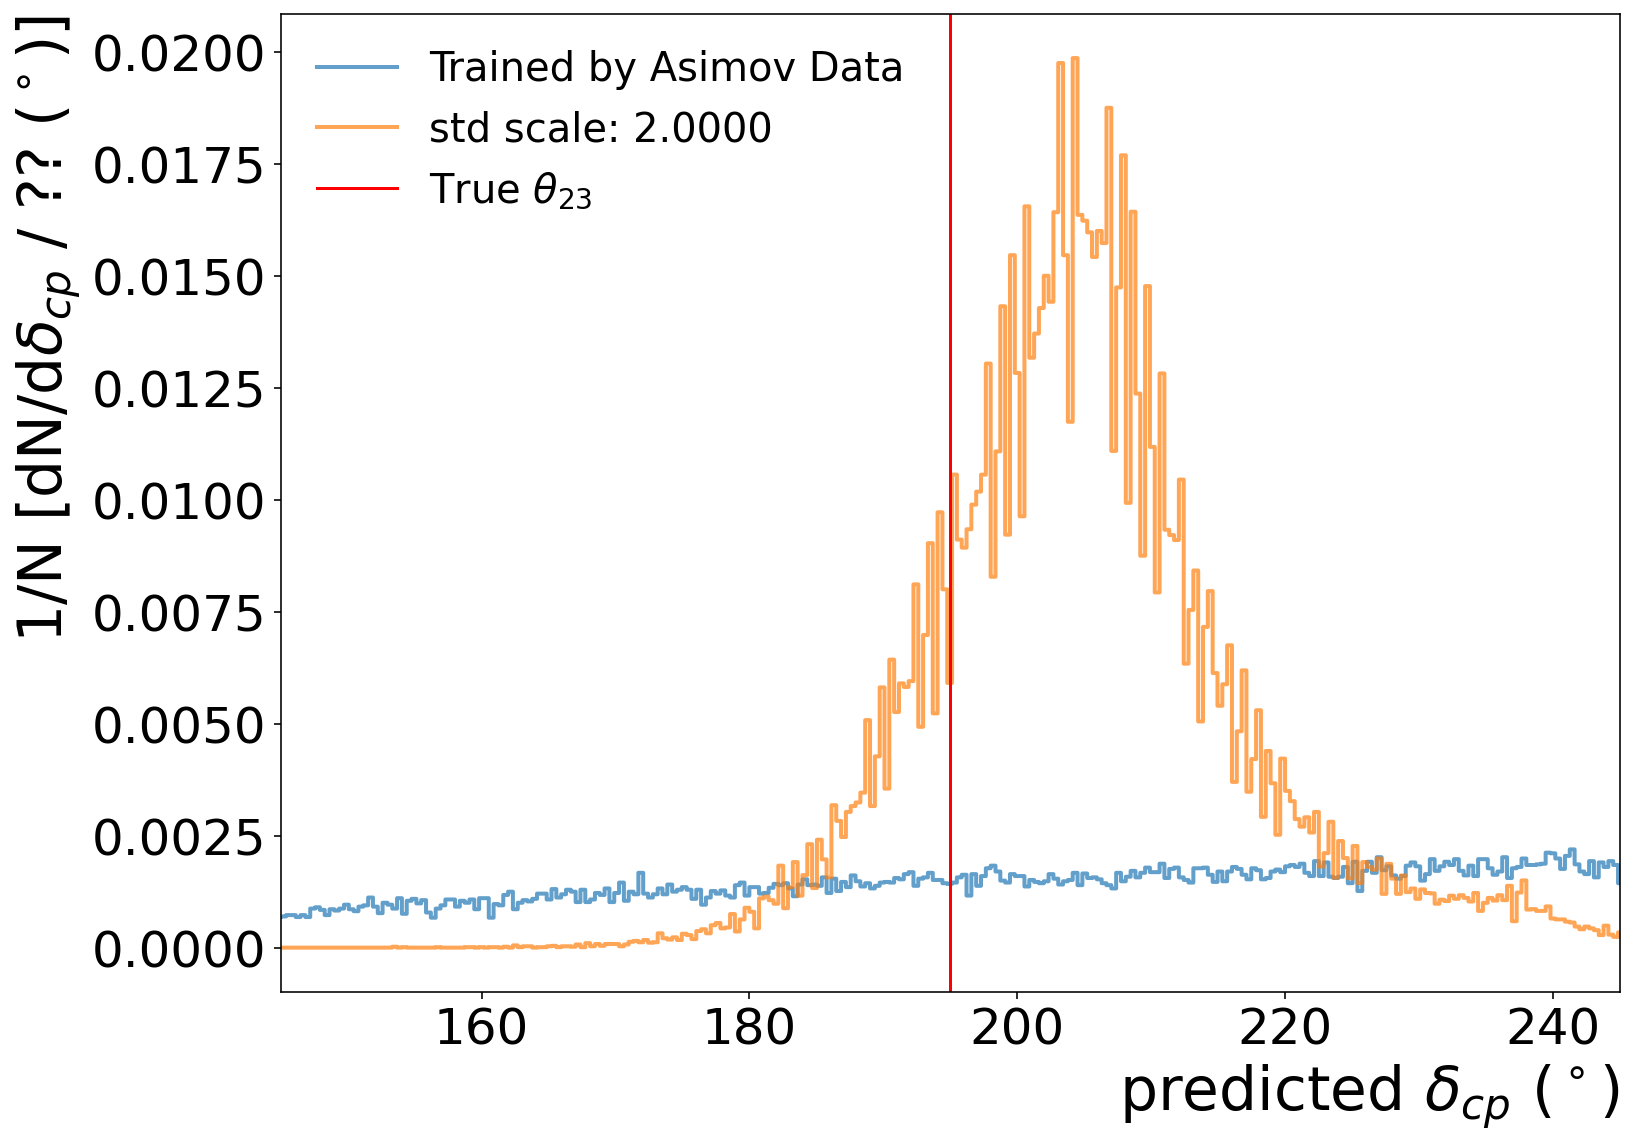

CPU times: user 325 ms, sys: 174 ms, total: 498 ms
Wall time: 317 ms


In [15]:
%%time
fig, ax = plt.subplots(1,1, figsize=(12,9))

"""
Trained by Asimov
"""

hist, bins = delta_resolution["asimov"]["hist"], bins_delta
plt.step(bins[:-1], 
         hist.astype(np.float32) / hist.sum() ,
#          hist.astype(np.float32) ,
         where='mid',
         linewidth=2, 
         alpha=0.7,
         label="Trained by Asimov Data"
        )

"""
Trained by Asymptotic Method
"""
# for i in scale_range[0,5,10,15,20,25,39]:
# for i in [0,5,10,15,25,37,38,39]:
for i in [39]:
    hist, bins = delta_resolution["std_scale_"+str(i)]["hist"], bins_delta
    plt.step(bins[:-1], 
             hist.astype(np.float32) / hist.sum() ,
    #          hist.astype(np.float32) ,
             where='mid',
             linewidth=2, 
             alpha=0.7,
             label="std scale: {:.4f}".format(np.logspace(-3, np.log10(2), 40)[i])
            )

plt.axvline(x=test_data['delta'][IO_or_NO] , color='r', linestyle='-', label="True $\\theta_{23}$")
    
    
ax.tick_params(axis='x', labelsize=25)
ax.tick_params(axis='y', labelsize=25)

if IO_or_NO == 0:
    plt.xlim((145,245))
elif IO_or_NO == 1:
    plt.xlim((236, 336))
             
# # plt.ylim((0., 0.18))
plt.xlabel("predicted $\delta_{cp}$ ($^\circ$)", fontsize=30,horizontalalignment='right',x=1)
plt.ylabel("1/N [dN/d$\delta_{cp}$ / ?? ($^\circ$)]", fontsize=30, horizontalalignment='right',y=1)

plt.legend(loc="best",ncol=1,fontsize=20, edgecolor = "w",fancybox=False, framealpha=0)
    


plt.show()

In [16]:
#總資料組數
N_DUNE = 92
N_T2HK = 36
N_DUT2 = 96

In [17]:
theta23_DUNE = []
delta_cp_DUNE = []
chi_DUNE = []
theta23_T2HK = []
delta_cp_T2HK = []
chi_T2HK = []
theta23_DUT2 = []
delta_cp_DUT2 = []
chi_DUT2 = []

In [18]:
%%time
#Import txt檔
f_DUNE = open("../Data/chi_square-4-2_figB_DUNE.txt")
for i in range(N_DUNE):
    s = f_DUNE.readline().split()
    array = []
    for j in range(len(s)) :
        array.append(float(s[j])) 
    theta23_DUNE.append(array[0])
    delta_cp_DUNE.append(array[1]) 
    chi_DUNE.append(array[2])
f_DUNE.close()
f_T2HK = open("../Data/chi_square-4-2_figB_T2HK.txt")
for i in range(N_T2HK):
    s = f_T2HK.readline().split()
    array = []
    for j in range(len(s)) :
        array.append(float(s[j])) 
    theta23_T2HK.append(array[0])
    delta_cp_T2HK.append(array[1]) 
    chi_T2HK.append(array[2])
f_T2HK.close()
f_DUT2 = open("../Data/chi_square-4-2_figB_DUT2.txt")
for i in range(N_DUT2):
    s = f_DUT2.readline().split()
    array = []
    for j in range(len(s)) :
        array.append(float(s[j])) 
    theta23_DUT2.append(array[0])
    delta_cp_DUT2.append(array[1]) 
    chi_DUT2.append(array[2])
f_DUT2.close()

CPU times: user 0 ns, sys: 1.78 ms, total: 1.78 ms
Wall time: 3.47 ms


In [19]:
theta23_DUNE = np.array(theta23_DUNE)
delta_cp_DUNE = np.array(delta_cp_DUNE)
chi_DUNE = np.array(chi_DUNE)
theta23_T2HK = np.array(theta23_T2HK)
delta_cp_T2HK = np.array(delta_cp_T2HK)
chi_T2HK = np.array(chi_T2HK)
theta23_DUT2 = np.array(theta23_DUT2)
delta_cp_DUT2 = np.array(delta_cp_DUT2)
chi_DUT2 = np.array(chi_DUT2)

In [20]:
%%time
x0 = np.linspace(min(theta23_DUNE)-3, max(theta23_DUNE)+3, 68)
y0 = np.linspace(min(delta_cp_DUNE)-6, max(delta_cp_DUNE)+6, 20)
X0, Y0 = np.meshgrid(x0, y0)
Z0 = np.zeros((len(X0),len(X0[0])))

for i in range(len(theta23_DUNE)):
    a = np.where(X0 == theta23_DUNE[i])[1][0]
    b = np.where(Y0 == delta_cp_DUNE[i])[0][0]
    Z0[b][a] = 1

x1 = np.linspace(min(theta23_T2HK)-3, max(theta23_T2HK)+3, 65)
y1 = np.linspace(min(delta_cp_T2HK)-6, max(delta_cp_T2HK)+6, 14)
X1, Y1 = np.meshgrid(x1, y1)
Z1 = np.zeros((len(X1),len(X1[0])))

for i in range(len(theta23_T2HK)):
    a = np.where(X1 == theta23_T2HK[i])[1][0]
    b = np.where(Y1 == delta_cp_T2HK[i])[0][0]
    Z1[b][a] = 1

x2 = np.linspace(min(theta23_DUT2)-3, max(theta23_DUT2)+3, 129)
y2 = np.linspace(min(delta_cp_DUT2)-6, max(delta_cp_DUT2)+6, 25)
X2, Y2 = np.meshgrid(x2, y2)
Z2 = np.zeros((len(X2),len(X2[0])))

for i in range(len(theta23_DUT2)):
    a = np.where(X2 == theta23_DUT2[i])[1][0]
    b = np.where(Y2 == delta_cp_DUT2[i])[0][0]
    Z2[b][a] = 1

CPU times: user 5.26 ms, sys: 982 µs, total: 6.25 ms
Wall time: 5.69 ms


In [21]:
theta23_resolution.keys()

dict_keys(['asimov', 'std_scale_0', 'std_scale_1', 'std_scale_2', 'std_scale_3', 'std_scale_4', 'std_scale_5', 'std_scale_6', 'std_scale_7', 'std_scale_8', 'std_scale_9', 'std_scale_10', 'std_scale_11', 'std_scale_12', 'std_scale_13', 'std_scale_14', 'std_scale_15', 'std_scale_16', 'std_scale_17', 'std_scale_18', 'std_scale_19', 'std_scale_20', 'std_scale_21', 'std_scale_22', 'std_scale_23', 'std_scale_24', 'std_scale_25', 'std_scale_26', 'std_scale_27', 'std_scale_28', 'std_scale_29', 'std_scale_30', 'std_scale_31', 'std_scale_32', 'std_scale_33', 'std_scale_34', 'std_scale_35', 'std_scale_36', 'std_scale_37', 'std_scale_38', 'std_scale_39'])

In [24]:
%%time
def countour_prepare(input_theta23,input_delta, bins_theta23_globes, bins_delta_globes):
    
    likeliregion, xedges, yedges = np.histogram2d(input_theta23, input_delta, 
                                                  bins = [bins_theta23_globes, bins_delta_globes]
                                                 )
    likeliregion = likeliregion.T

    max_poi = np.where(likeliregion == likeliregion.max())
    logging.info("Maximum: theta23: {:.2f}, delta: {:.2f} ".format(xedges[max_poi[1]][0],yedges[max_poi[0]][0]))
    sorted_list = np.sort(likeliregion.reshape((len(xedges)-1)*(len(yedges)-1)))[::-1]

    tot_event_num = sorted_list.sum()

    onesigma = 0
    for i in range(len(sorted_list)):
        onesigma += sorted_list[i]
        if onesigma/tot_event_num >= 0.68:
            one_sigma_num = sorted_list[i]
            break

    twosigma = 0
    for i in range(len(sorted_list)):
        twosigma += sorted_list[i]        
        if twosigma/tot_event_num >= 0.95:
            two_sigma_num = sorted_list[i]
            break

    one_sigma_region = np.where(likeliregion < one_sigma_num, 0, likeliregion )
    one_sigma_region_boundary = np.where(one_sigma_region > 0, 1, one_sigma_region )
    one_sigma_allowed_region = np.where(one_sigma_region_boundary != 0)

    two_sigma_region = np.where(likeliregion < two_sigma_num, 0, likeliregion )
    two_sigma_region_boundary = np.where(two_sigma_region > 0, 1, two_sigma_region )
    two_sigma_allowed_region = np.where(two_sigma_region_boundary != 0)

    xaxis, yaxis = (xedges[:-1] + xedges[1:])/2, (yedges[:-1] + yedges[1:])/2
    
    
    
    return one_sigma_region_boundary, two_sigma_region_boundary, xaxis, yaxis, xedges, yedges, max_poi 

"""
Learnt Asimov Data
"""

input_theta23_asimov = theta23_resolution["asimov"]["poission_prediction"]
input_delta_asimov = delta_resolution["asimov"]["poission_prediction"]

bins_theta23_globes = np.linspace(0, 360, int(360/(x0[1]-x0[0])))
bins_delta_globes  = np.linspace(0, 360, int(360/(y0[1]-y0[0])))

one_sigma_region_boundary_asimov, two_sigma_region_boundary_asimov, xaxis_asimov, yaxis_asimov, xedges_asimov, yedges_asimov, max_poi_asimov = countour_prepare(input_theta23_asimov,
                                                                                                                                                                input_delta_asimov,
                                                                                                                                                                bins_theta23_globes,
                                                                                                                                                                bins_delta_globes
                                                                                                                                                                )
          

"""
Learnt Poisson Noise
"""

index = 2
input_theta23 = theta23_resolution["std_scale_"+str(index)]["poission_prediction"]
input_delta = delta_resolution["std_scale_"+str(index)]["poission_prediction"]

bins_theta23_globes = np.linspace(0, 360, int(360/(x0[1]-x0[0])))
bins_delta_globes  = np.linspace(0, 360, int(360/(y0[1]-y0[0])))

one_sigma_region_boundary, two_sigma_region_boundary, xaxis, yaxis, xedges, yedges, max_poi = countour_prepare(input_theta23,
                                                                                                               input_delta,
                                                                                                               bins_theta23_globes,
                                                                                                               bins_delta_globes
                                                                                                               )
                                                                           

INFO:root:Maximum: theta23: 65.54, delta: 197.09 
INFO:root:Maximum: theta23: 48.93, delta: 195.08 


CPU times: user 129 ms, sys: 3.66 ms, total: 133 ms
Wall time: 131 ms


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:53: UserWarning: No contour levels were found within the data range.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: No contour levels were found within the data range.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: No contour levels were found within the data range.


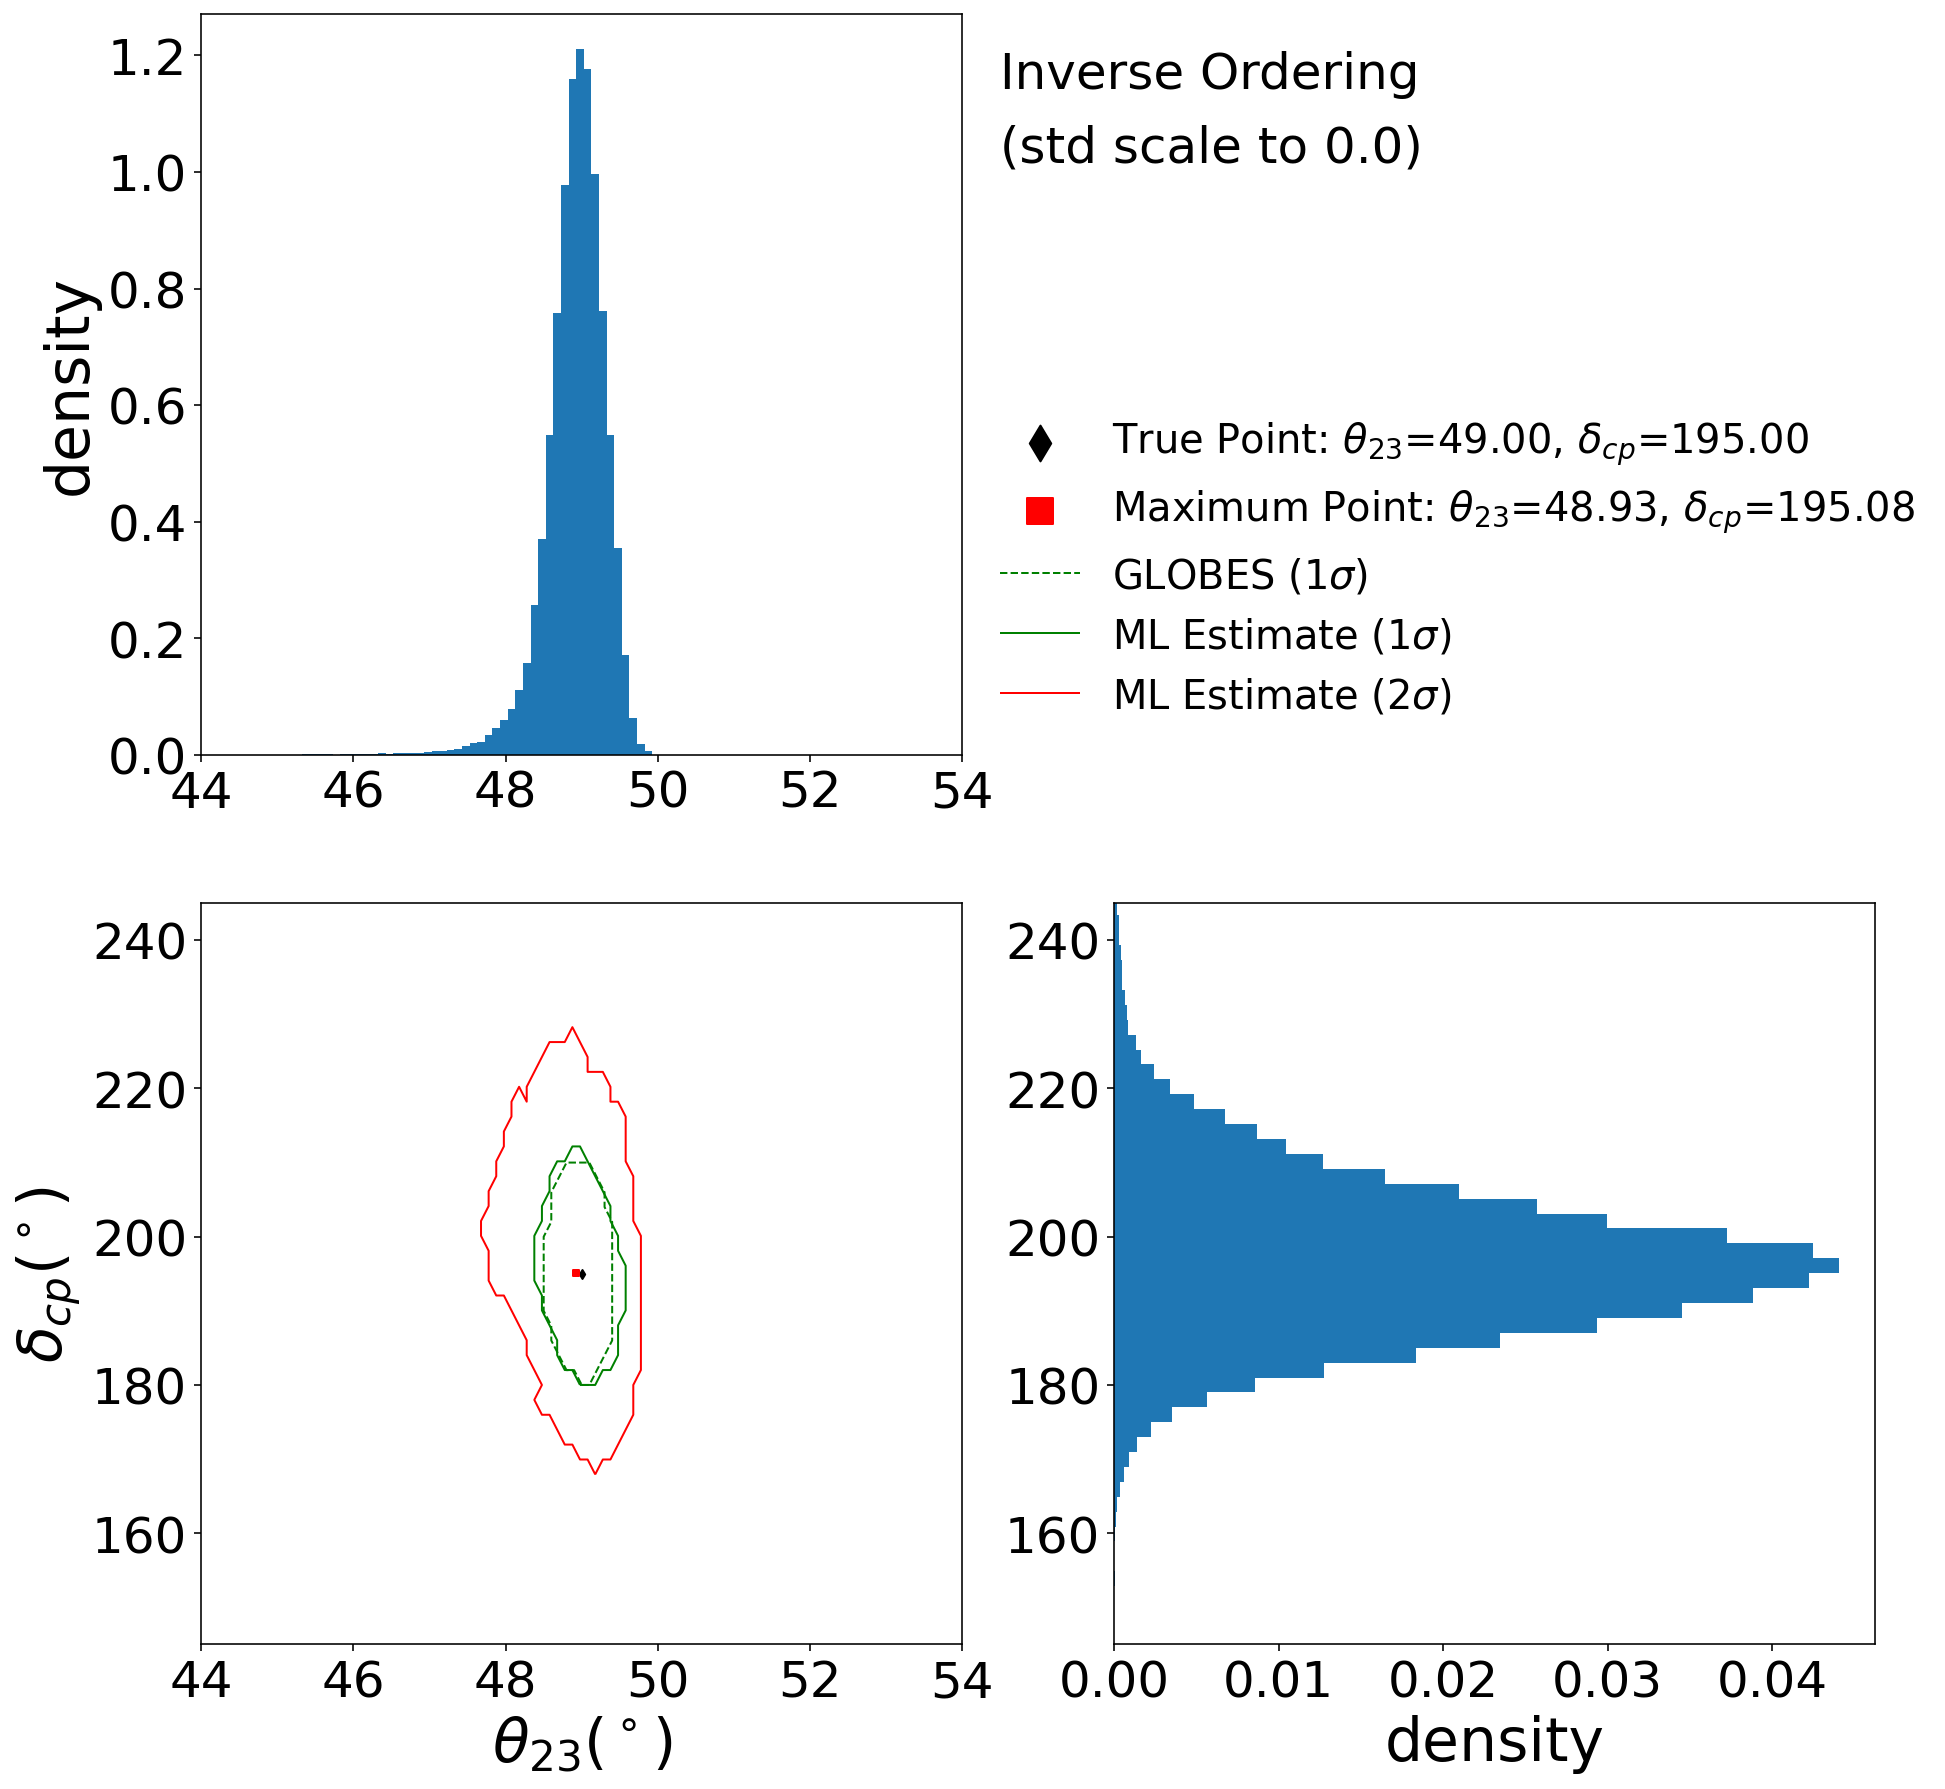

In [25]:
fig, ax = plt.subplots(1,1, figsize=(15,15))

#=========================== Upper Left Corner
plot_axis = plt.subplot(2,2,1)
"""
ML
"""
plot_axis.hist(input_theta23,density=1,bins=bins_theta23_globes)
if IO_or_NO == 0:
    plot_axis.set_xlim((44,54))
elif IO_or_NO == 1:
    plot_axis.set_xlim((44,54))
plot_axis.tick_params(axis='x', labelsize=25)
plot_axis.tick_params(axis='y', labelsize=25)
plot_axis.set_ylabel(r'density', fontsize=30)
#===========================




#=========================== Down Right Corner
plot_axis = plt.subplot(2,2,4)
"""
ML
"""
plot_axis.hist(input_delta,orientation="horizontal",density=1, bins=bins_delta_globes)
if IO_or_NO == 0:
    plot_axis.set_ylim((145,245))
elif IO_or_NO == 1:
    plot_axis.set_ylim((236, 336))
plot_axis.tick_params(axis='x', labelsize=25)
plot_axis.tick_params(axis='y', labelsize=25)
plot_axis.set_xlabel(r'density', fontsize=30)
#===========================


#=========================== Down Left Corner
plot_axis = plt.subplot(2,2,3)


if IO_or_NO == 0:
    plot_axis.scatter(test_data['theta23'][0], test_data['delta'][0], marker="d", c="k", s=10, label = "True Point: $\\theta_{23}$=%.2f, $\delta_{cp}$=%.2f" %(test_data['theta23'][0], test_data['delta'][0]))
else:
    plot_axis.scatter(test_data['theta23'][1], test_data['delta'][1], marker="d", c="k", s=10, label = "True Point: $\\theta_{23}$=%.2f, $\delta_{cp}$=%.2f" %(test_data['theta23'][1], test_data['delta'][1]))

plot_axis.scatter(xedges[max_poi[1]],yedges[max_poi[0]], marker="s", c="r", s=10, label = "Maximum Point: $\\theta_{23}$=%.2f, $\delta_{cp}$=%.2f" %(xedges[max_poi[1]][0], yedges[max_poi[0]][0]))
# plot_axis.scatter(xedges_asimov[max_poi_asimov[1]],yedges_asimov[max_poi_asimov[0]], marker="d", c="blue", s=5, label = "maximum point: $\\theta_{23}$=%.2f, $\delta_{cp}$=%.2f" %(xedges_asimov[max_poi_asimov[1]][0], yedges_asimov[max_poi_asimov[0]][0]))

    
"""
globes
"""
DUT2 = plot_axis.contour(X0, Y0, Z0, 0, colors='green', linestyles="--", linewidths=1 )
DUT2.collections[0].set_label("GLOBES (1$\sigma$)")

# DUT2 = plot_axis.contour(X1, Y1, Z1, 0, colors='blue', linestyles="-", linewidths=1)
# DUT2.collections[0].set_label("T2HK")

# DUT2 = plot_axis.contour(X2, Y2, Z2, 0, colors='blue', linestyles="-", linewidths=1)
# DUT2.collections[0].set_label("DUNE + T2HK")



# """
# ML (Asimov)
# """
# CS_1_sigma_asimov = plt.contour(xaxis_asimov, yaxis_asimov, one_sigma_region_boundary_asimov, 0, colors='green', linestyles=":", linewidths=1)
# CS_2_sigma_asimov = plt.contour(xaxis_asimov, yaxis_asimov, two_sigma_region_boundary_asimov, 0, colors='red', linestyles=":", linewidths=1)
# CS_1_sigma_asimov.collections[0].set_label("Learnt Asimov (1$\sigma$)")
# CS_2_sigma_asimov.collections[0].set_label("Learnt Asimov (2$\sigma$)")



"""
ML (Poisson)
"""
CS_1_sigma = plt.contour(xaxis, yaxis, one_sigma_region_boundary, 0, colors='green', linestyles="-", linewidths=1)
CS_2_sigma = plt.contour(xaxis, yaxis, two_sigma_region_boundary, 0, colors='red', linestyles="-", linewidths=1)
CS_1_sigma.collections[0].set_label("ML Estimate (1$\sigma$)")
CS_2_sigma.collections[0].set_label("ML Estimate (2$\sigma$)")


plot_axis.set_xlabel(r'$\theta_{23} $($^\circ$)', fontsize=30)
plot_axis.set_ylabel(r'$\delta_{cp} $($^\circ$)', fontsize=30)
if IO_or_NO == 0:
    plot_axis.set_ylim((145,245))
    plot_axis.set_xlim((44,54))
elif IO_or_NO == 1:
    plot_axis.set_ylim((236, 336))
    plot_axis.set_xlim((44,54))
else:
    raise ValueError("aaaa")
    
    
plot_axis.tick_params(axis='x', labelsize=25)
plot_axis.tick_params(axis='y', labelsize=25)
#===========================
                              
    

#=========================== Whole Figure Setting

if IO_or_NO == 0:
    plt.text(x=54.5,y=355, s="Inverse Ordering", fontsize=25 )
    plt.text(x=54.5,y=345, s="(std scale to " + str(round(np.logspace(-3, np.log10(2), 40)[index],2))+")", fontsize=25 )
    
elif IO_or_NO == 1:
    plt.text(x=54.5,y=440, s="Normal Ordering", fontsize=25 )
    plt.text(x=54.5,y=430, s="(std scale to " + str(round(np.logspace(-3, np.log10(2), 40)[index],2))+")", fontsize=25 )
    
# plt.subplots_adjust(wspace=0.15, hspace=0.01)
plt.legend(bbox_to_anchor=(2.3, 1.7), ncol=1,fontsize=20, markerscale=4, edgecolor = "w",fancybox=False, framealpha=0)
# plt.savefig("./Plots/"+str(experiment)+"_"+str("to_5GeV")+"_"+str(ordering)+"_std_"+str(int(round(np.logspace(-3, np.log10(2), 40)[index],2)*100))+".pdf", transparent=True, bbox_inches='tight') 
plt.show()